### Zespół 4:
- Jakub Smuga
- Konrad Korus
- Maksym Kazhaiev

## Imports



In [ ]:
!pip install SALib
!pip install ucimlrepo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol
from SALib.analyze import pawn
from SALib.sample import saltelli
from scipy.stats import ks_2samp
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
import time
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

In [ ]:
from enum import Enum

class AnalysisMethod(Enum):
    SOBOL = "Sobol"
    PAWN = "Pawn"

## Helper functions

In [ ]:
random_shuffle_state = 2024

def train_valid_test_split(features, targets, valid_p = 0.1, test_p = 0.3):
  # shuffle the features and targets in the same way
  features = shuffle(features, random_state = random_shuffle_state)
  targets = shuffle(targets, random_state = random_shuffle_state)
  train_size = int(len(features) * (1 - (test_p + valid_p)))
  valid_size = int(len(features) * valid_p)

  X_train, X_valid, X_test = features[:train_size], features[train_size:train_size + valid_size], features[train_size + valid_size:]
  y_train, y_valid, y_test = targets[:train_size], targets[train_size:train_size + valid_size], targets[train_size + valid_size:]
  return (X_train, y_train, X_valid, y_valid, X_test, y_test)

In [ ]:
def plot_accuracy(removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(train_accuracy_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, train_accuracy_history, marker='o', linestyle='-', color='b', label='Train Accuracy')
    plt.plot(removed_inputs_history, valid_accuracy_history, marker='s', linestyle='-', color='g', label='Validation Accuracy')
    plt.plot(removed_inputs_history, test_accuracy_history, marker='^', linestyle='-', color='r', label='Test Accuracy')

    plt.xlabel('Removed Input History')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_time(removed_inputs_history, time_history):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(time_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, time_history, label='Time')

    plt.xlabel('Removed Input History')
    plt.ylabel('Time')
    plt.title('Time during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_analysis(removed_inputs_history, analysis_history, average_analysis_history, label):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(analysis_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, analysis_history, label=f"{label} analysis value for removed neuron")
    plt.plot(removed_inputs_history, average_analysis_history, label=f"{label} Average analysis value")

    plt.xlabel('Removed Input History')
    plt.ylabel('Analysis')
    plt.title(f'{label} Analysis during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

def load_model(model, filename):
    model.load_state_dict(torch.load(filename))

##First Layer

In [ ]:
# Definicja modelu MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.out(x)
        return self.softmax(x)

In [ ]:
def trainAndGetLowestAnalysisValueForFirstLayer (model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor,  X_test_tensor, y_test_tensor, analysis_method, columns):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    batch_size = 32

    problem = {
        'num_vars':  X_train_tensor.shape[1],
        'names': [f'x{i+1}' for i in range( X_train_tensor.shape[1])],
        'bounds': [[0, 1]] *  X_train_tensor.shape[1]
    }

    learning_time_start = time.time()
    for epoch in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i+batch_size]
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            outputs = model(X_train_tensor)
            _, predicted = torch.max(outputs, 1)
            train_accuracy = (predicted == y_train_tensor).sum().item() / len(y_train_tensor)

            outputs = model(X_valid_tensor)
            _, predicted = torch.max(outputs, 1)
            valid_accuracy = (predicted == y_valid_tensor).sum().item() / len(y_valid_tensor)

            outputs = model(X_test_tensor)
            _, predicted = torch.max(outputs, 1)
            test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)

            if epoch == epochs - 1:
                learning_time = time.time() - learning_time_start;
                print(f"Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}, , Test Accuracy: {test_accuracy:.4f}")

                param_values = sobol_sample.sample(problem, 1024)
                param_tensor = torch.tensor(param_values, dtype=torch.float32)

                if analysis_method == AnalysisMethod.SOBOL:
                  Y = model(param_tensor).detach().numpy().flatten()
                  Si = sobol.analyze(problem, Y, print_to_console=False)
                  min_sobol_index=np.argmin(Si['S1'])
                  avarage_value=np.mean(Si['S1'])
                  print(f"[Sobol] Dropping neuron with index {min_sobol_index} (column: {columns[min_sobol_index]}) |  Sobol value =  {Si['S1'][min_sobol_index]:.5f} | Avg Sobol value: {avarage_value:.5f}")
                  return min_sobol_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['S1'][min_sobol_index], avarage_value

                elif analysis_method == AnalysisMethod.PAWN:
                  Y = model(param_tensor)
                  _, Y = torch.max(Y, 1)
                  Si = pawn.analyze(problem, param_values, Y, print_to_console=False)
                  min_pawn_index=np.argmin(Si['median'])
                  avarage_value=np.mean(Si['median'])
                  print(f"[PAWN] Dropping neuron with index {min_pawn_index} (column: {columns[min_pawn_index]}) |  PAWN value =  {Si['CV'][min_pawn_index]:.5f} | Avg PAWN value: {avarage_value:.5f} ")
                  return  min_pawn_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['CV'][min_pawn_index], avarage_value

                else:
                  print("Wrong analysis method!")


def trainWhileRemovingInputsBasedOnAnalysisForFirstLayer (X, y, hiddden_dim, analysis_method):
    removed_inputs_history = []
    train_accuracy_history = []
    valid_accuracy_history = []
    test_accuracy_history = []
    time_history = []
    analysis_history = []
    average_analysis_history = []

    for trainIndex in range(len(X.columns)):
        print(f"---------------------------------------- Iteration {trainIndex+1} ----------------------------------------")
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        input_dim = X_train_tensor.shape[1]
        output_dim = len(np.unique(y_train))
        model = MLP(input_dim, hidden_dim, output_dim)

        removed_input, train_accureacy, valid_accuracy, test_accuracy, time, analysis_value, average_analysis_value = trainAndGetLowestAnalysisValueForFirstLayer(model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, analysis_method, X.columns)
        removed_inputs_history.append(X.columns[removed_input])
        train_accuracy_history.append(train_accureacy)
        valid_accuracy_history.append(valid_accuracy)
        test_accuracy_history.append(test_accuracy)
        time_history.append(time)
        analysis_history.append(analysis_value)
        average_analysis_history.append(average_analysis_value)

        X = X.drop(X.columns[removed_input], axis=1)
        print("")


    return removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history, time_history, analysis_history, average_analysis_history

## Second Layer


In [ ]:
# Definicja modelu MLP
class MLP2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.layer2(x)
        x = self.relu(x)
        x = self.out(x)
        return self.softmax(x)


# Definicja modelu MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.out(x)
        return self.softmax(x)

In [ ]:
def trainAndGetLowestAnalysisValueForSecondLayer (model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, dim, analysis_method):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    batch_size = 32

    problem = {
        'num_vars': dim,
        'names': [i for i in range(dim)],
        'bounds': [[0, 1]] * dim
    }

    bounds = np.array([[0, 1]] * dim)

    learning_time_start = time.time()
    for epoch in range(epochs):

        for i in range(0, len(X_train_tensor), batch_size):
            inputs = model.relu(model.fc1(X_train_tensor[i:i+batch_size]))
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            outputs = model(model.relu(model.fc1(X_train_tensor)))
            _, predicted = torch.max(outputs, 1)
            train_accuracy = (predicted == y_train_tensor).sum().item() / len(y_train_tensor)

            outputs = model(model.relu(model.fc1(X_valid_tensor)))
            _, predicted = torch.max(outputs, 1)
            valid_accuracy = (predicted == y_valid_tensor).sum().item() / len(y_valid_tensor)

            outputs = model(model.relu(model.fc1(X_test_tensor)))
            _, predicted = torch.max(outputs, 1)
            test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)


            if epoch == epochs - 1:
                learning_time = time.time() - learning_time_start;
                print(f"Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

                param_values = sobol_sample.sample(problem, 1024)
                param_tensor = torch.tensor(param_values, dtype=torch.float32)

                if analysis_method == AnalysisMethod.SOBOL:
                  Y = model(param_tensor).detach().numpy().flatten()
                  Si = sobol.analyze(problem, Y, print_to_console=False)
                  min_sobol_index=np.argmin(Si['S1'])
                  avarage_value=np.mean(Si['S1'])
                  print(f"[Sobol] Dropping neuron with index {min_sobol_index} |  Sobol value =  {Si['S1'][min_sobol_index]:.5f} | Avg Sobol value: {avarage_value:.5f}")
                  return min_sobol_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['S1'][min_sobol_index], avarage_value

                elif analysis_method == AnalysisMethod.PAWN:
                  Y = model(param_tensor)
                  _, Y = torch.max(Y, 1)
                  Si = pawn.analyze(problem, param_values, Y, print_to_console=False)
                  min_pawn_index=np.argmin(Si['median'])
                  avarage_value=np.mean(Si['median'])
                  print(f"[PAWN] Dropping neuron with index {min_pawn_index} |  PAWN value =  {Si['median'][min_pawn_index]:.5f} | Avg PAWN value: {avarage_value:.5f} ")
                  return  min_pawn_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, min_pawn_index, avarage_value

                else:
                  print("Wrong analysis method!")

def trainWhileRemovingInputsBasedOnAnalysisForSecondLayer (X, y, hidden_dim, analysis_method):
    removed_inputs_history = []
    train_accuracy_history = []
    valid_accuracy_history = []
    test_accuracy_history = []
    time_history = []
    analysis_history = []
    average_analysis_history = []

    for trainIndex in range(hidden_dim):

        print(f"---------------------------------------- Iteration {trainIndex+1} ----------------------------------------")
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        input_dim = X_train_tensor.shape[1]
        output_dim = len(np.unique(y_train))
        model = MLP2(input_dim, hidden_dim, output_dim)

        removed_input, train_accureacy, valid_accuracy, test_accuracy, time, analysis_value, average_analysis_value = trainAndGetLowestAnalysisValueForSecondLayer(model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, hidden_dim, analysis_method)
        removed_inputs_history.append(removed_input)
        train_accuracy_history.append(train_accureacy)
        valid_accuracy_history.append(valid_accuracy)
        test_accuracy_history.append(test_accuracy)
        time_history.append(time)
        analysis_history.append(analysis_value)
        average_analysis_history.append(average_analysis_value)

        hidden_dim -= 1
        print("")

    return removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history, time_history, analysis_history, average_analysis_history

## Usuwanie neuronów z pierwszej warstwy - SOBOL

In [ ]:
breast_cancer = fetch_ucirepo(id=17)
breast_cancer.data.targets['Diagnosis'] = breast_cancer.data.targets['Diagnosis'] == 'M'

X = breast_cancer.data.features
y = breast_cancer.data.targets

hidden_dim = 32
removed_inputs_history_first_sobol, train_accuracy_history_first_sobol, valid_accuracy_history_first_sobol, test_accuracy_history_first_sobol, time_history_first_sobol, analysis_history_first_sobol, average_analysis_history_first_sobol = trainWhileRemovingInputsBasedOnAnalysisForFirstLayer(X, y, hidden_dim, AnalysisMethod.SOBOL)

<ipython-input-26-44028fcc8ee4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_cancer.data.targets['Diagnosis'] = breast_cancer.data.targets['Diagnosis'] == 'M'
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------------------------------------- Iteration 1 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.3859, Training Accuracy: 0.9912, Valid Accuracy: 0.9643, , Test Accuracy: 0.9826
[Sobol] Dropping neuron with index 23 (column: area3) |  Sobol value =  -0.00014 | Avg Sobol value: 0.99993

---------------------------------------- Iteration 2 ----------------------------------------
Loss: 0.3855, Training Accuracy: 0.9853, Valid Accuracy: 0.9643, , Test Accuracy: 0.9826


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 21 (column: texture3) |  Sobol value =  -0.00023 | Avg Sobol value: 1.03427

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 0.3682, Training Accuracy: 0.9765, Valid Accuracy: 0.9464, , Test Accuracy: 0.9767


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 15 (column: compactness2) |  Sobol value =  -0.00014 | Avg Sobol value: 0.99991

---------------------------------------- Iteration 4 ----------------------------------------
Loss: 0.3854, Training Accuracy: 0.9736, Valid Accuracy: 0.9643, , Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 25 (column: symmetry3) |  Sobol value =  0.00004 | Avg Sobol value: 1.03696

---------------------------------------- Iteration 5 ----------------------------------------
Loss: 0.3677, Training Accuracy: 0.9677, Valid Accuracy: 0.9643, , Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 9 (column: fractal_dimension1) |  Sobol value =  -0.00003 | Avg Sobol value: 0.99996

---------------------------------------- Iteration 6 ----------------------------------------
Loss: 0.3988, Training Accuracy: 0.9677, Valid Accuracy: 0.9464, , Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 17 (column: fractal_dimension2) |  Sobol value =  -0.00020 | Avg Sobol value: 1.03984

---------------------------------------- Iteration 7 ----------------------------------------
Loss: 0.3898, Training Accuracy: 0.9736, Valid Accuracy: 0.9643, , Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 21 (column: concavity3) |  Sobol value =  -0.00039 | Avg Sobol value: 0.99964

---------------------------------------- Iteration 8 ----------------------------------------
Loss: 0.3818, Training Accuracy: 0.9619, Valid Accuracy: 0.9464, , Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 21 (column: concave_points3) |  Sobol value =  -0.00015 | Avg Sobol value: 1.04328

---------------------------------------- Iteration 9 ----------------------------------------
Loss: 0.4038, Training Accuracy: 0.9501, Valid Accuracy: 0.9643, , Test Accuracy: 0.9535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 21 (column: fractal_dimension3) |  Sobol value =  -0.00024 | Avg Sobol value: 0.99958

---------------------------------------- Iteration 10 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.3958, Training Accuracy: 0.9619, Valid Accuracy: 0.9643, , Test Accuracy: 0.9651
[Sobol] Dropping neuron with index 9 (column: radius2) |  Sobol value =  -0.00006 | Avg Sobol value: 1.04740

---------------------------------------- Iteration 11 ----------------------------------------
Loss: 0.3839, Training Accuracy: 0.9560, Valid Accuracy: 0.9643, , Test Accuracy: 0.9535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 17 (column: perimeter3) |  Sobol value =  -0.00022 | Avg Sobol value: 0.99973

---------------------------------------- Iteration 12 ----------------------------------------
Loss: 0.4131, Training Accuracy: 0.9589, Valid Accuracy: 0.9643, , Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 17 (column: smoothness3) |  Sobol value =  -0.00037 | Avg Sobol value: 1.05195

---------------------------------------- Iteration 13 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.4168, Training Accuracy: 0.9472, Valid Accuracy: 0.9643, , Test Accuracy: 0.9593
[Sobol] Dropping neuron with index 17 (column: compactness3) |  Sobol value =  -0.00022 | Avg Sobol value: 0.99957

---------------------------------------- Iteration 14 ----------------------------------------
Loss: 0.4180, Training Accuracy: 0.9413, Valid Accuracy: 0.9464, , Test Accuracy: 0.9360


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 15 (column: symmetry2) |  Sobol value =  -0.00012 | Avg Sobol value: 1.05545

---------------------------------------- Iteration 15 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.4434, Training Accuracy: 0.9208, Valid Accuracy: 0.9464, , Test Accuracy: 0.9535
[Sobol] Dropping neuron with index 15 (column: radius3) |  Sobol value =  0.00006 | Avg Sobol value: 0.99936

---------------------------------------- Iteration 16 ----------------------------------------
Loss: 0.4318, Training Accuracy: 0.9413, Valid Accuracy: 0.9464, , Test Accuracy: 0.9477


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 9 (column: texture2) |  Sobol value =  0.00040 | Avg Sobol value: 1.06658

---------------------------------------- Iteration 17 ----------------------------------------
Loss: 0.4505, Training Accuracy: 0.9413, Valid Accuracy: 0.9464, , Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 7 (column: concave_points1) |  Sobol value =  -0.00027 | Avg Sobol value: 0.99977

---------------------------------------- Iteration 18 ----------------------------------------
Loss: 0.4713, Training Accuracy: 0.9208, Valid Accuracy: 0.9464, , Test Accuracy: 0.9302


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 9 (column: area2) |  Sobol value =  -0.00045 | Avg Sobol value: 1.07542

---------------------------------------- Iteration 19 ----------------------------------------
Loss: 0.4578, Training Accuracy: 0.9238, Valid Accuracy: 0.9464, , Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 9 (column: smoothness2) |  Sobol value =  -0.00065 | Avg Sobol value: 0.99907

---------------------------------------- Iteration 20 ----------------------------------------
Loss: 0.4700, Training Accuracy: 0.9238, Valid Accuracy: 0.9464, , Test Accuracy: 0.9360


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 7 (column: symmetry1) |  Sobol value =  -0.00013 | Avg Sobol value: 1.08887

---------------------------------------- Iteration 21 ----------------------------------------
Loss: 0.4388, Training Accuracy: 0.9326, Valid Accuracy: 0.9464, , Test Accuracy: 0.9302


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 9 (column: concave_points2) |  Sobol value =  -0.00196 | Avg Sobol value: 0.99738

---------------------------------------- Iteration 22 ----------------------------------------
Loss: 0.4510, Training Accuracy: 0.9150, Valid Accuracy: 0.9464, , Test Accuracy: 0.9360


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 7 (column: perimeter2) |  Sobol value =  0.00021 | Avg Sobol value: 1.11061

---------------------------------------- Iteration 23 ----------------------------------------
Loss: 0.4483, Training Accuracy: 0.9267, Valid Accuracy: 0.9464, , Test Accuracy: 0.9360


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 7 (column: concavity2) |  Sobol value =  -0.00170 | Avg Sobol value: 0.99772

---------------------------------------- Iteration 24 ----------------------------------------
Loss: 0.4444, Training Accuracy: 0.9267, Valid Accuracy: 0.9464, , Test Accuracy: 0.9360


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 3 (column: area1) |  Sobol value =  -0.00191 | Avg Sobol value: 1.13723

---------------------------------------- Iteration 25 ----------------------------------------
Loss: 0.4533, Training Accuracy: 0.9326, Valid Accuracy: 0.9464, , Test Accuracy: 0.9419


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 (column: texture1) |  Sobol value =  0.00151 | Avg Sobol value: 0.99504

---------------------------------------- Iteration 26 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.4268, Training Accuracy: 0.9267, Valid Accuracy: 0.9286, , Test Accuracy: 0.9186
[Sobol] Dropping neuron with index 3 (column: compactness1) |  Sobol value =  0.00229 | Avg Sobol value: 1.19295

---------------------------------------- Iteration 27 ----------------------------------------
Loss: 0.4428, Training Accuracy: 0.9150, Valid Accuracy: 0.9286, , Test Accuracy: 0.9070


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 3 (column: concavity1) |  Sobol value =  0.00687 | Avg Sobol value: 0.97878

---------------------------------------- Iteration 28 ----------------------------------------
Loss: 0.4384, Training Accuracy: 0.8944, Valid Accuracy: 0.9107, , Test Accuracy: 0.8663


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 (column: perimeter1) |  Sobol value =  0.02201 | Avg Sobol value: 1.25670

---------------------------------------- Iteration 29 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.4196, Training Accuracy: 0.9091, Valid Accuracy: 0.9107, , Test Accuracy: 0.8895
[Sobol] Dropping neuron with index 1 (column: smoothness1) |  Sobol value =  0.00519 | Avg Sobol value: 0.92150

---------------------------------------- Iteration 30 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.4532, Training Accuracy: 0.8915, Valid Accuracy: 0.8929, , Test Accuracy: 0.8721
[Sobol] Dropping neuron with index 0 (column: radius1) |  Sobol value =  0.66664 | Avg Sobol value: 0.66664



removed_inputs_history:
['area3', 'texture3', 'compactness2', 'symmetry3', 'fractal_dimension1', 'fractal_dimension2', 'concavity3', 'concave_points3', 'fractal_dimension3', 'radius2', 'perimeter3', 'smoothness3', 'compactness3', 'symmetry2', 'radius3', 'texture2', 'concave_points1', 'area2', 'smoothness2', 'symmetry1', 'concave_points2', 'perimeter2', 'concavity2', 'area1', 'texture1', 'compactness1', 'concavity1', 'perimeter1', 'smoothness1', 'radius1']
train_accuracy_history:
[0.9912023460410557, 0.9853372434017595, 0.9765395894428153, 0.9736070381231672, 0.967741935483871, 0.967741935483871, 0.9736070381231672, 0.9618768328445748, 0.9501466275659824, 0.9618768328445748, 0.9560117302052786, 0.9589442815249267, 0.9472140762463344, 0.9413489736070382, 0.9208211143695014, 0.9413489736070382, 0.9413489736070382, 0.9208211143695014, 0.9237536656891495, 0.9237536656891495, 0.9325513196480938, 0.9149560117302052, 0.9266862170087976, 0.9266862170087976, 0.9325513196480938, 0.926686217008797

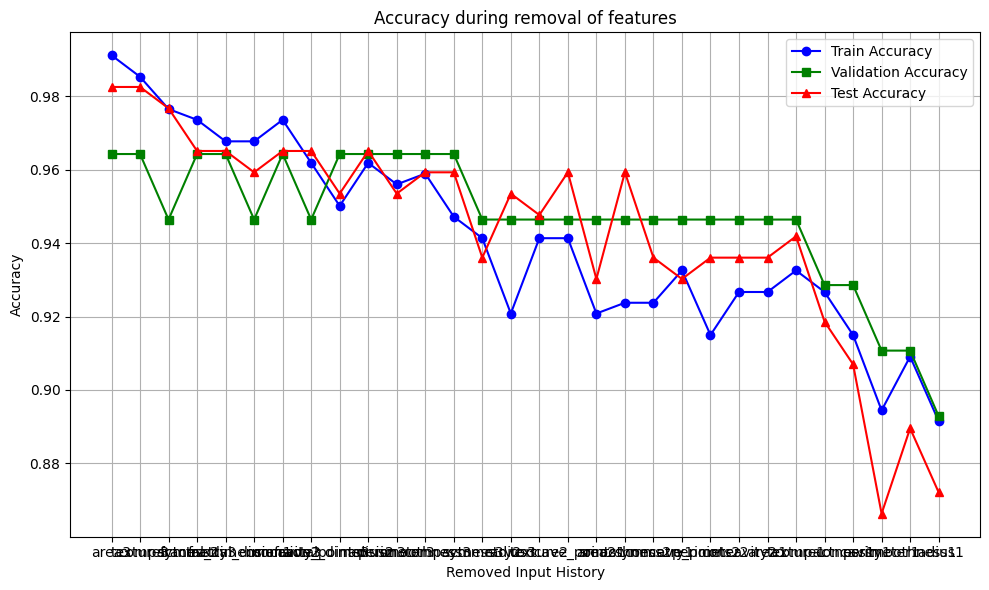

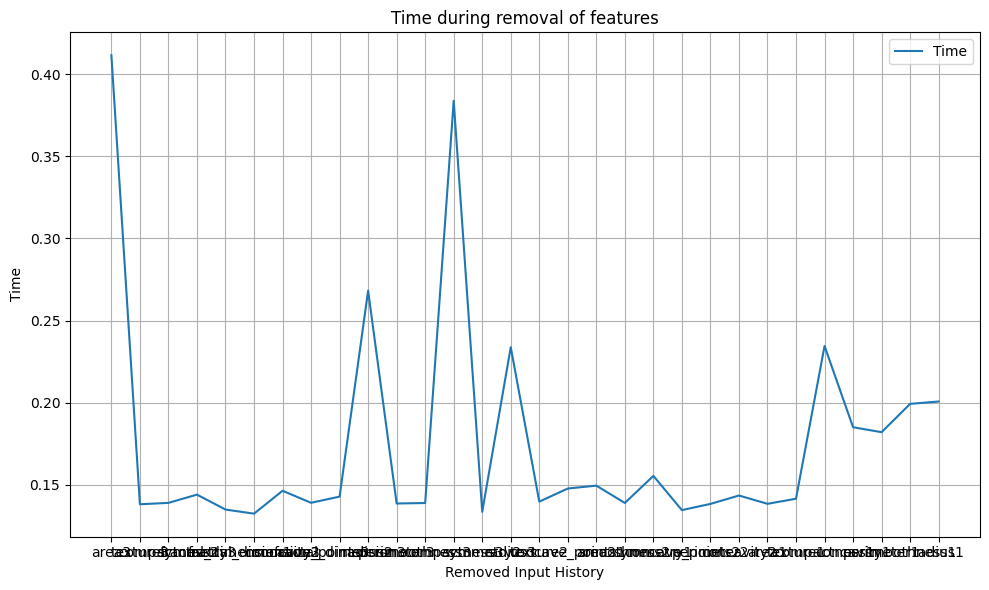

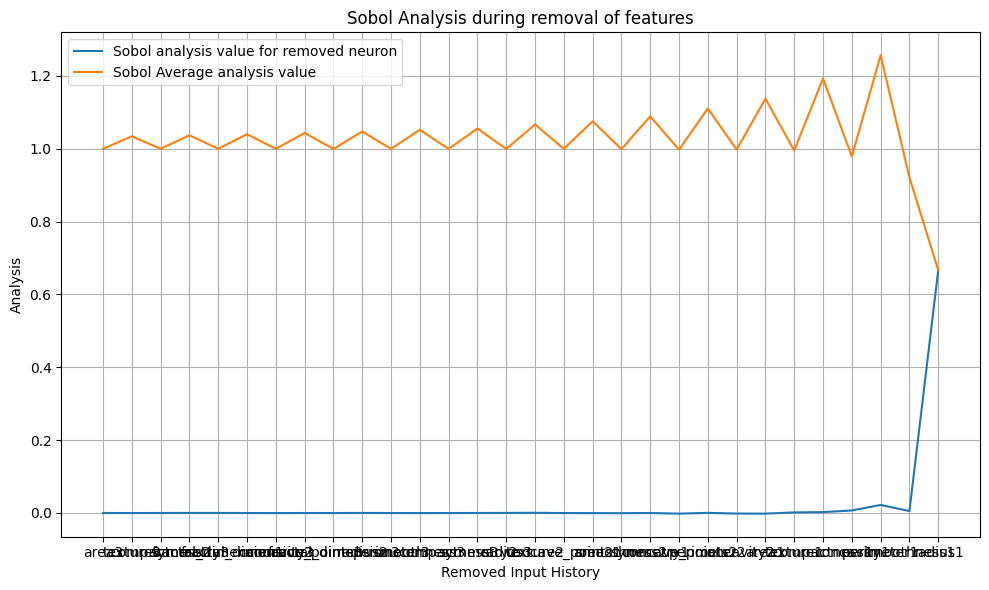

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_first_sobol)
print("train_accuracy_history:")
print(train_accuracy_history_first_sobol)
print("valid_accuracy_history:")
print(valid_accuracy_history_first_sobol)
print("test_accuracy_history:")
print(test_accuracy_history_first_sobol)
print("time_history:")
print(time_history_first_sobol)
plot_accuracy(removed_inputs_history_first_sobol, train_accuracy_history_first_sobol, valid_accuracy_history_first_sobol, test_accuracy_history_first_sobol)
plot_time(removed_inputs_history_first_sobol, time_history_first_sobol)
plot_analysis(removed_inputs_history_first_sobol, analysis_history_first_sobol, average_analysis_history_first_sobol, "Sobol")

# Usuwanie neuronów z drugiej warstwy - SOBOL


In [ ]:
breast_cancer = fetch_ucirepo(id=17)
breast_cancer.data.targets['Diagnosis'] = breast_cancer.data.targets['Diagnosis'] == 'M'

X = breast_cancer.data.features
X = X.drop('area3', axis=1)
X = X.drop('texture3', axis=1)
X = X.drop('compactness2', axis=1)
X = X.drop('symmetry3', axis=1)
X = X.drop('fractal_dimension1', axis=1)
X = X.drop('fractal_dimension2', axis=1)


y = breast_cancer.data.targets

hidden_dim = 32


removed_inputs_history_second_sobol, train_accuracy_history_second_sobol, valid_accuracy_history_second_sobol, test_accuracy_history_second_sobol, time_history_second_sobol, analysis_history_second_sobol, average_analysis_history_second_sobol = trainWhileRemovingInputsBasedOnAnalysisForSecondLayer(X, y, hidden_dim, AnalysisMethod.SOBOL)

<ipython-input-28-d1a5a8d5dfae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_cancer.data.targets['Diagnosis'] = breast_cancer.data.targets['Diagnosis'] == 'M'
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.3793, Training Accuracy: 0.9765, Valid Accuracy: 0.9464, Test Accuracy: 0.9651
[Sobol] Dropping neuron with index 31 |  Sobol value =  -0.00303 | Avg Sobol value: 0.99462

---------------------------------------- Iteration 2 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.3892, Training Accuracy: 0.9619, Valid Accuracy: 0.9464, Test Accuracy: 0.9651
[Sobol] Dropping neuron with index 9 |  Sobol value =  -0.00182 | Avg Sobol value: 1.02860

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 0.3886, Training Accuracy: 0.9707, Valid Accuracy: 0.9464, Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 25 |  Sobol value =  -0.00126 | Avg Sobol value: 0.99572

---------------------------------------- Iteration 4 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.4169, Training Accuracy: 0.9472, Valid Accuracy: 0.9464, Test Accuracy: 0.9477
[Sobol] Dropping neuron with index 27 |  Sobol value =  -0.00005 | Avg Sobol value: 1.03375

---------------------------------------- Iteration 5 ----------------------------------------
Loss: 0.3809, Training Accuracy: 0.9531, Valid Accuracy: 0.9286, Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 9 |  Sobol value =  -0.00197 | Avg Sobol value: 0.98578

---------------------------------------- Iteration 6 ----------------------------------------
Loss: 0.4101, Training Accuracy: 0.9443, Valid Accuracy: 0.9643, Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 19 |  Sobol value =  -0.00017 | Avg Sobol value: 1.03173

---------------------------------------- Iteration 7 ----------------------------------------
Loss: 0.4056, Training Accuracy: 0.9472, Valid Accuracy: 0.9464, Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 9 |  Sobol value =  -0.00079 | Avg Sobol value: 0.99807

---------------------------------------- Iteration 8 ----------------------------------------
Loss: 0.3883, Training Accuracy: 0.9589, Valid Accuracy: 0.9643, Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 |  Sobol value =  0.00534 | Avg Sobol value: 1.01259

---------------------------------------- Iteration 9 ----------------------------------------
Loss: 0.4292, Training Accuracy: 0.9413, Valid Accuracy: 0.9643, Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 7 |  Sobol value =  0.00046 | Avg Sobol value: 0.99651

---------------------------------------- Iteration 10 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.3888, Training Accuracy: 0.9619, Valid Accuracy: 0.9464, Test Accuracy: 0.9709
[Sobol] Dropping neuron with index 7 |  Sobol value =  -0.00019 | Avg Sobol value: 1.03499

---------------------------------------- Iteration 11 ----------------------------------------
Loss: 0.4206, Training Accuracy: 0.9472, Valid Accuracy: 0.9643, Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 15 |  Sobol value =  -0.00713 | Avg Sobol value: 0.99075

---------------------------------------- Iteration 12 ----------------------------------------
Loss: 0.4387, Training Accuracy: 0.9296, Valid Accuracy: 0.9464, Test Accuracy: 0.9419


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 13 |  Sobol value =  -0.00241 | Avg Sobol value: 1.01973

---------------------------------------- Iteration 13 ----------------------------------------
Loss: 0.4072, Training Accuracy: 0.9472, Valid Accuracy: 0.9464, Test Accuracy: 0.9535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 17 |  Sobol value =  0.01123 | Avg Sobol value: 0.96881

---------------------------------------- Iteration 14 ----------------------------------------
Loss: 0.3977, Training Accuracy: 0.9443, Valid Accuracy: 0.9464, Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 17 |  Sobol value =  -0.00983 | Avg Sobol value: 1.04037

---------------------------------------- Iteration 15 ----------------------------------------
Loss: 0.4355, Training Accuracy: 0.9472, Valid Accuracy: 0.9464, Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 |  Sobol value =  -0.00004 | Avg Sobol value: 0.99824

---------------------------------------- Iteration 16 ----------------------------------------
Loss: 0.4000, Training Accuracy: 0.9355, Valid Accuracy: 0.9464, Test Accuracy: 0.9360


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 7 |  Sobol value =  0.00548 | Avg Sobol value: 1.04044

---------------------------------------- Iteration 17 ----------------------------------------
Loss: 0.4165, Training Accuracy: 0.9443, Valid Accuracy: 0.9286, Test Accuracy: 0.9419


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 9 |  Sobol value =  0.00122 | Avg Sobol value: 0.99144

---------------------------------------- Iteration 18 ----------------------------------------
Loss: 0.4187, Training Accuracy: 0.9384, Valid Accuracy: 0.9464, Test Accuracy: 0.9477


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 |  Sobol value =  0.00391 | Avg Sobol value: 1.05828

---------------------------------------- Iteration 19 ----------------------------------------
Loss: 0.4221, Training Accuracy: 0.9501, Valid Accuracy: 0.9464, Test Accuracy: 0.9477


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 7 |  Sobol value =  -0.02097 | Avg Sobol value: 0.93883

---------------------------------------- Iteration 20 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.4199, Training Accuracy: 0.9296, Valid Accuracy: 0.9464, Test Accuracy: 0.9419
[Sobol] Dropping neuron with index 11 |  Sobol value =  0.00519 | Avg Sobol value: 1.05706

---------------------------------------- Iteration 21 ----------------------------------------
Loss: 0.4513, Training Accuracy: 0.9355, Valid Accuracy: 0.9643, Test Accuracy: 0.9535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 3 |  Sobol value =  0.00885 | Avg Sobol value: 0.95391

---------------------------------------- Iteration 22 ----------------------------------------
Loss: 0.4620, Training Accuracy: 0.9179, Valid Accuracy: 0.9643, Test Accuracy: 0.9477


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 9 |  Sobol value =  0.03552 | Avg Sobol value: 1.06843

---------------------------------------- Iteration 23 ----------------------------------------
Loss: 0.4619, Training Accuracy: 0.9384, Valid Accuracy: 0.9643, Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 5 |  Sobol value =  -0.04083 | Avg Sobol value: 0.84417

---------------------------------------- Iteration 24 ----------------------------------------
Loss: 0.5473, Training Accuracy: 0.6393, Valid Accuracy: 0.6786, Test Accuracy: 0.5872


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 5 |  Sobol value =  -0.00023 | Avg Sobol value: 1.10992

---------------------------------------- Iteration 25 ----------------------------------------
Loss: 0.5206, Training Accuracy: 0.9150, Valid Accuracy: 0.9107, Test Accuracy: 0.9244


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 |  Sobol value =  0.00106 | Avg Sobol value: 0.99746

---------------------------------------- Iteration 26 ----------------------------------------
Loss: 0.5877, Training Accuracy: 0.9150, Valid Accuracy: 0.9643, Test Accuracy: 0.9419


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 |  Sobol value =  0.04596 | Avg Sobol value: 1.05903

---------------------------------------- Iteration 27 ----------------------------------------
Loss: 0.4637, Training Accuracy: 0.9296, Valid Accuracy: 0.9286, Test Accuracy: 0.9360


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 |  Sobol value =  0.00795 | Avg Sobol value: 0.95043

---------------------------------------- Iteration 28 ----------------------------------------
Loss: 0.5667, Training Accuracy: 0.9003, Valid Accuracy: 0.9464, Test Accuracy: 0.9477


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 |  Sobol value =  0.10619 | Avg Sobol value: 1.13521

---------------------------------------- Iteration 29 ----------------------------------------
Loss: 0.5717, Training Accuracy: 0.9150, Valid Accuracy: 0.9464, Test Accuracy: 0.9360


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 3 |  Sobol value =  -0.10027 | Avg Sobol value: 0.68035

---------------------------------------- Iteration 30 ----------------------------------------
Loss: 0.6064, Training Accuracy: 0.9267, Valid Accuracy: 0.9643, Test Accuracy: 0.9302


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Sobol] Dropping neuron with index 1 |  Sobol value =  0.13444 | Avg Sobol value: 1.00032

---------------------------------------- Iteration 31 ----------------------------------------
Loss: 0.6519, Training Accuracy: 0.9062, Valid Accuracy: 0.9464, Test Accuracy: 0.8953
[Sobol] Dropping neuron with index 1 |  Sobol value =  0.02308 | Avg Sobol value: 0.57783

---------------------------------------- Iteration 32 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.6625, Training Accuracy: 0.6393, Valid Accuracy: 0.6786, Test Accuracy: 0.5872
[Sobol] Dropping neuron with index 0 |  Sobol value =  1.97055 | Avg Sobol value: 1.97055



removed_inputs_history:
[31, 9, 25, 27, 9, 19, 9, 1, 7, 7, 15, 13, 17, 17, 1, 7, 9, 1, 7, 11, 3, 9, 5, 5, 1, 1, 1, 1, 3, 1, 1, 0]
train_accuracy_history:
[0.9765395894428153, 0.9618768328445748, 0.9706744868035191, 0.9472140762463344, 0.9530791788856305, 0.9442815249266863, 0.9472140762463344, 0.9589442815249267, 0.9413489736070382, 0.9618768328445748, 0.9472140762463344, 0.9296187683284457, 0.9472140762463344, 0.9442815249266863, 0.9472140762463344, 0.9354838709677419, 0.9442815249266863, 0.9384164222873901, 0.9501466275659824, 0.9296187683284457, 0.9354838709677419, 0.9178885630498533, 0.9384164222873901, 0.6392961876832844, 0.9149560117302052, 0.9149560117302052, 0.9296187683284457, 0.9002932551319648, 0.9149560117302052, 0.9266862170087976, 0.906158357771261, 0.6392961876832844]
valid_accuracy_history:
[0.9464285714285714, 0.9464285714285714, 0.9464285714285714, 0.9464285714285714, 0.9285714285714286, 0.9642857142857143, 0.9464285714285714, 0.9642857142857143, 0.9642857142857143, 0

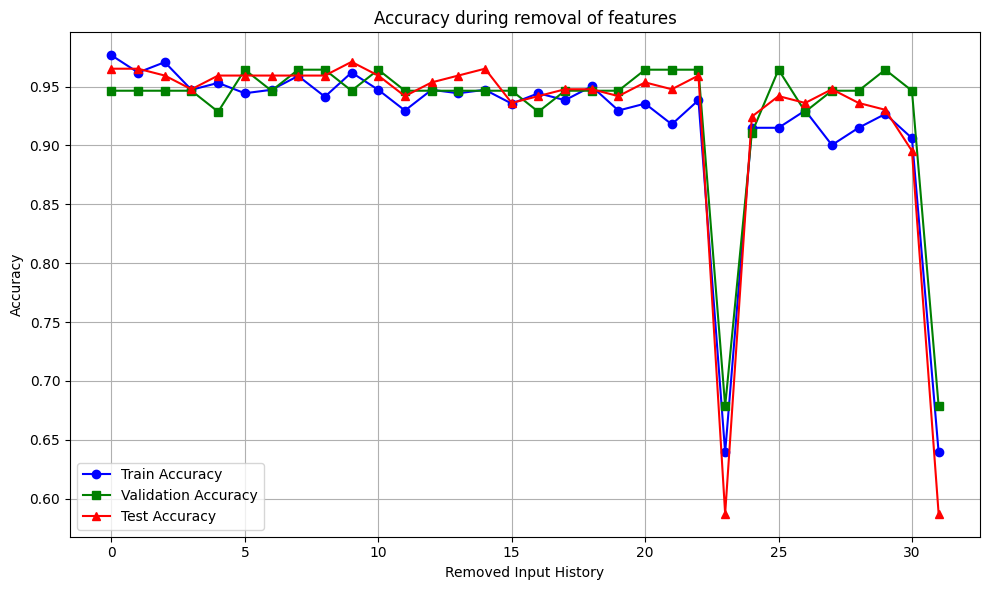

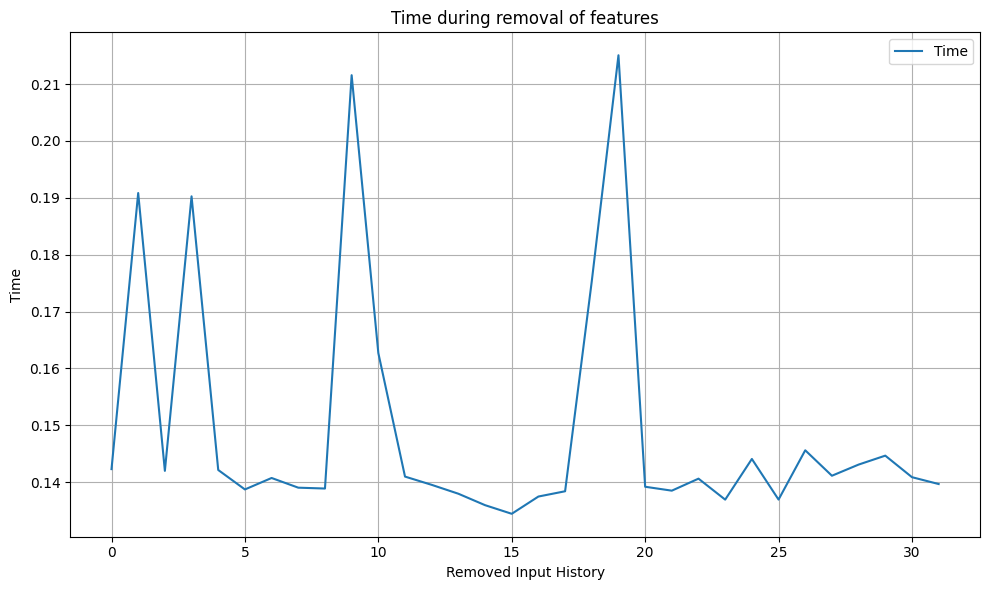

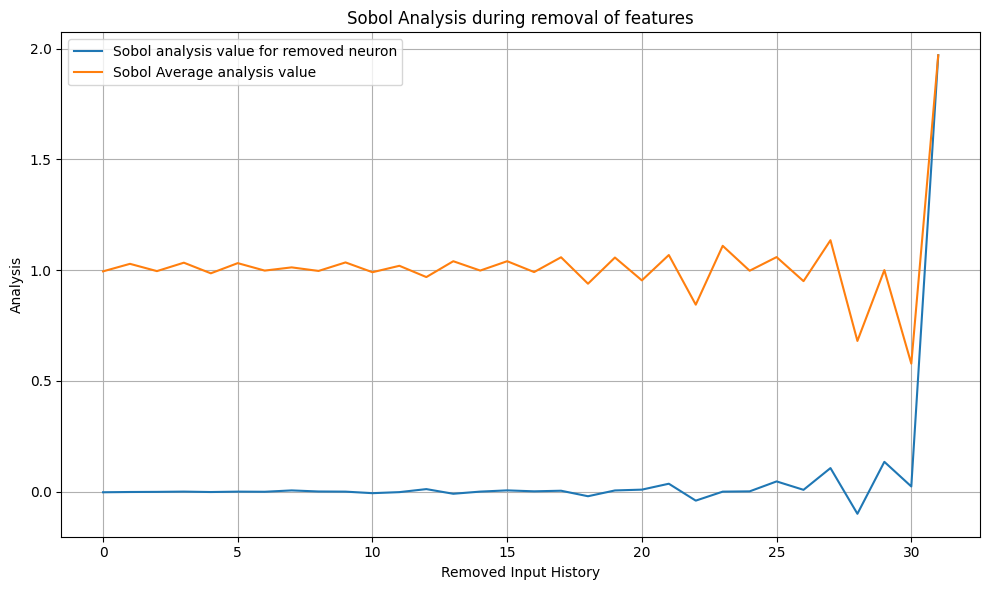

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_second_sobol)
print("train_accuracy_history:")
print(train_accuracy_history_second_sobol)
print("valid_accuracy_history:")
print(valid_accuracy_history_second_sobol)
print("test_accuracy_history:")
print(test_accuracy_history_second_sobol)
print("time_history:")
print(time_history_second_sobol)
plot_accuracy(None, train_accuracy_history_second_sobol, valid_accuracy_history_second_sobol, test_accuracy_history_second_sobol)
plot_time(None, time_history_second_sobol)
plot_analysis(None, analysis_history_second_sobol, average_analysis_history_second_sobol, "Sobol")

# Usuwanie neuronów z pierwszej warstwy - PAWN

In [ ]:
breast_cancer = fetch_ucirepo(id=17)
breast_cancer.data.targets['Diagnosis'] = breast_cancer.data.targets['Diagnosis'] == 'M'

X = breast_cancer.data.features
y = breast_cancer.data.targets

hidden_dim = 32

removed_inputs_history_first_pawn, train_accuracy_history_first_pawn, valid_accuracy_history_first_pawn, test_accuracy_history_first_pawn, time_history_first_pawn, analysis_history_first_pawn, average_analysis_history_first_pawn = trainWhileRemovingInputsBasedOnAnalysisForFirstLayer(X, y, hidden_dim, AnalysisMethod.PAWN)

<ipython-input-30-46321e4bbabf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_cancer.data.targets['Diagnosis'] = breast_cancer.data.targets['Diagnosis'] == 'M'
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.3748, Training Accuracy: 0.9853, Valid Accuracy: 0.9643, , Test Accuracy: 0.9767


/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: radius1) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 2 ----------------------------------------
Loss: 0.3940, Training Accuracy: 0.9853, Valid Accuracy: 0.9643, , Test Accuracy: 0.9767


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: texture1) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 0.3775, Training Accuracy: 0.9795, Valid Accuracy: 0.9464, , Test Accuracy: 0.9767


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: perimeter1) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 4 ----------------------------------------
Loss: 0.3832, Training Accuracy: 0.9912, Valid Accuracy: 0.9643, , Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: area1) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 5 ----------------------------------------
Loss: 0.3866, Training Accuracy: 0.9883, Valid Accuracy: 0.9643, , Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: smoothness1) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 6 ----------------------------------------
Loss: 0.3766, Training Accuracy: 0.9736, Valid Accuracy: 0.9643, , Test Accuracy: 0.9709


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: compactness1) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 7 ----------------------------------------
Loss: 0.3923, Training Accuracy: 0.9824, Valid Accuracy: 0.9643, , Test Accuracy: 0.9767


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: concavity1) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 8 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.3763, Training Accuracy: 0.9883, Valid Accuracy: 0.9643, , Test Accuracy: 0.9767


/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: concave_points1) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 9 ----------------------------------------
Loss: 0.3917, Training Accuracy: 0.9795, Valid Accuracy: 0.9643, , Test Accuracy: 0.9709


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 (column: symmetry1) |  PAWN value =  1.38736 | Avg PAWN value: 0.00021 

---------------------------------------- Iteration 10 ----------------------------------------
Loss: 0.4010, Training Accuracy: 0.9824, Valid Accuracy: 0.9643, , Test Accuracy: 0.9709


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: fractal_dimension1) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 11 ----------------------------------------
Loss: 0.4296, Training Accuracy: 0.9648, Valid Accuracy: 0.9464, , Test Accuracy: 0.9767


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: radius2) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 12 ----------------------------------------
Loss: 0.3860, Training Accuracy: 0.9707, Valid Accuracy: 0.9464, , Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: texture2) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 13 ----------------------------------------
Loss: 0.3916, Training Accuracy: 0.9736, Valid Accuracy: 0.9464, , Test Accuracy: 0.9709


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: perimeter2) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 14 ----------------------------------------
Loss: 0.3928, Training Accuracy: 0.9736, Valid Accuracy: 0.9107, , Test Accuracy: 0.9535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: area2) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 15 ----------------------------------------
Loss: 0.3912, Training Accuracy: 0.9707, Valid Accuracy: 0.9107, , Test Accuracy: 0.9767


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 1 (column: compactness2) |  PAWN value =  1.33702 | Avg PAWN value: 0.00045 

---------------------------------------- Iteration 16 ----------------------------------------
Loss: 0.4027, Training Accuracy: 0.9677, Valid Accuracy: 0.9464, , Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 (column: smoothness2) |  PAWN value =  0.74924 | Avg PAWN value: 0.00006 

---------------------------------------- Iteration 17 ----------------------------------------
Loss: 0.4092, Training Accuracy: 0.9736, Valid Accuracy: 0.9464, , Test Accuracy: 0.9709


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: concavity2) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 18 ----------------------------------------
Loss: 0.4451, Training Accuracy: 0.9677, Valid Accuracy: 0.9464, , Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: concave_points2) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 19 ----------------------------------------
Loss: 0.4214, Training Accuracy: 0.9589, Valid Accuracy: 0.9643, , Test Accuracy: 0.9709


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 11 (column: fractal_dimension3) |  PAWN value =  0.75846 | Avg PAWN value: 0.00138 

---------------------------------------- Iteration 20 ----------------------------------------
Loss: 0.4205, Training Accuracy: 0.9648, Valid Accuracy: 0.9643, , Test Accuracy: 0.9709


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 (column: symmetry2) |  PAWN value =  1.03497 | Avg PAWN value: 0.00037 

---------------------------------------- Iteration 21 ----------------------------------------
Loss: 0.4259, Training Accuracy: 0.9619, Valid Accuracy: 0.9464, , Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 (column: fractal_dimension2) |  PAWN value =  1.02587 | Avg PAWN value: 0.00062 

---------------------------------------- Iteration 22 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.4314, Training Accuracy: 0.9589, Valid Accuracy: 0.9643, , Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 (column: radius3) |  PAWN value =  nan | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 23 ----------------------------------------
Loss: 0.4275, Training Accuracy: 0.9413, Valid Accuracy: 0.9107, , Test Accuracy: 0.9419
[PAWN] Dropping neuron with index 0 (column: texture3) |  PAWN value =  1.33696 | Avg PAWN value: 0.00011 

---------------------------------------- Iteration 24 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.4283, Training Accuracy: 0.9531, Valid Accuracy: 0.9286, , Test Accuracy: 0.9477
[PAWN] Dropping neuron with index 0 (column: perimeter3) |  PAWN value =  1.02884 | Avg PAWN value: 0.00024 

---------------------------------------- Iteration 25 ----------------------------------------
Loss: 0.4413, Training Accuracy: 0.9531, Valid Accuracy: 0.8929, , Test Accuracy: 0.9477


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 2 (column: compactness3) |  PAWN value =  0.69322 | Avg PAWN value: 0.00144 

---------------------------------------- Iteration 26 ----------------------------------------
Loss: 0.4481, Training Accuracy: 0.9472, Valid Accuracy: 0.9286, , Test Accuracy: 0.9419


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 4 (column: symmetry3) |  PAWN value =  0.49184 | Avg PAWN value: 0.02196 

---------------------------------------- Iteration 27 ----------------------------------------
Loss: 0.4315, Training Accuracy: 0.9413, Valid Accuracy: 0.8929, , Test Accuracy: 0.9302


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 1 (column: smoothness3) |  PAWN value =  0.73072 | Avg PAWN value: 0.01071 

---------------------------------------- Iteration 28 ----------------------------------------
Loss: 0.4339, Training Accuracy: 0.9472, Valid Accuracy: 0.9107, , Test Accuracy: 0.9360


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 1 (column: concavity3) |  PAWN value =  0.56530 | Avg PAWN value: 0.02766 

---------------------------------------- Iteration 29 ----------------------------------------
Loss: 0.4179, Training Accuracy: 0.9413, Valid Accuracy: 0.9464, , Test Accuracy: 0.9360


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 (column: area3) |  PAWN value =  0.88297 | Avg PAWN value: 0.03727 

---------------------------------------- Iteration 30 ----------------------------------------
Loss: 0.4994, Training Accuracy: 0.9150, Valid Accuracy: 0.8750, , Test Accuracy: 0.9186


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 (column: concave_points3) |  PAWN value =  0.26212 | Avg PAWN value: 0.37305 



removed_inputs_history:
['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'compactness2', 'smoothness2', 'concavity2', 'concave_points2', 'fractal_dimension3', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'compactness3', 'symmetry3', 'smoothness3', 'concavity3', 'area3', 'concave_points3']
train_accuracy_history:
[0.9853372434017595, 0.9853372434017595, 0.9794721407624634, 0.9912023460410557, 0.9882697947214076, 0.9736070381231672, 0.9824046920821115, 0.9882697947214076, 0.9794721407624634, 0.9824046920821115, 0.9648093841642229, 0.9706744868035191, 0.9736070381231672, 0.9736070381231672, 0.9706744868035191, 0.967741935483871, 0.9736070381231672, 0.967741935483871, 0.9589442815249267, 0.9648093841642229, 0.9618768328445748, 0.9589442815249267, 0.9413489736070382, 0.9530791788856305, 0.9530791788856305, 0.947214076246334

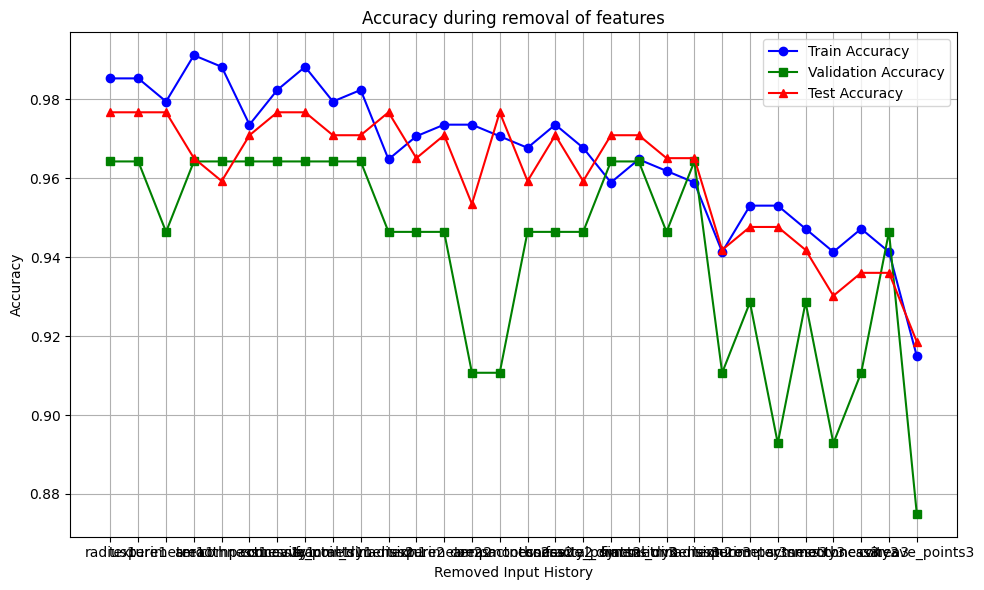

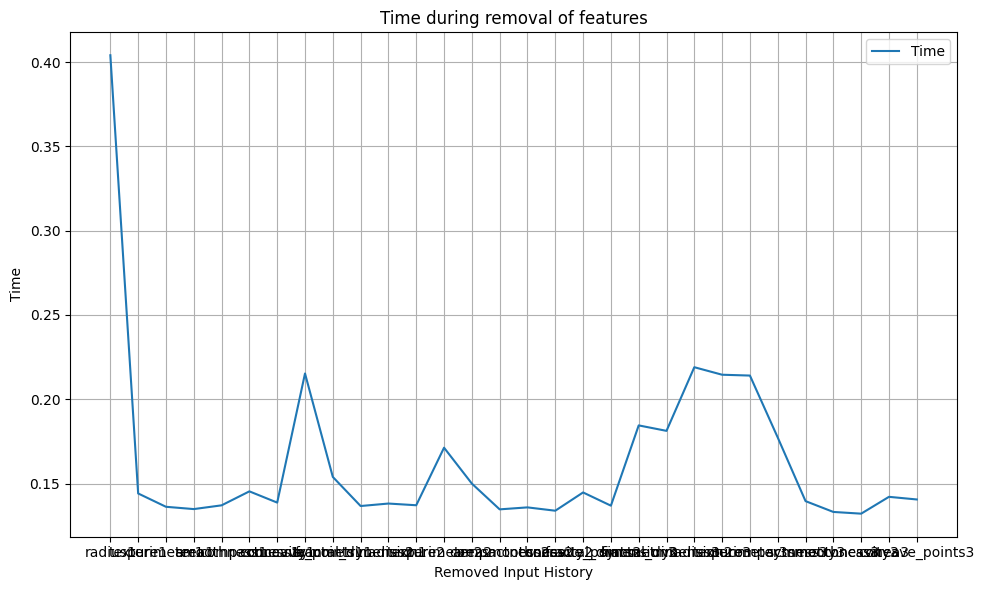

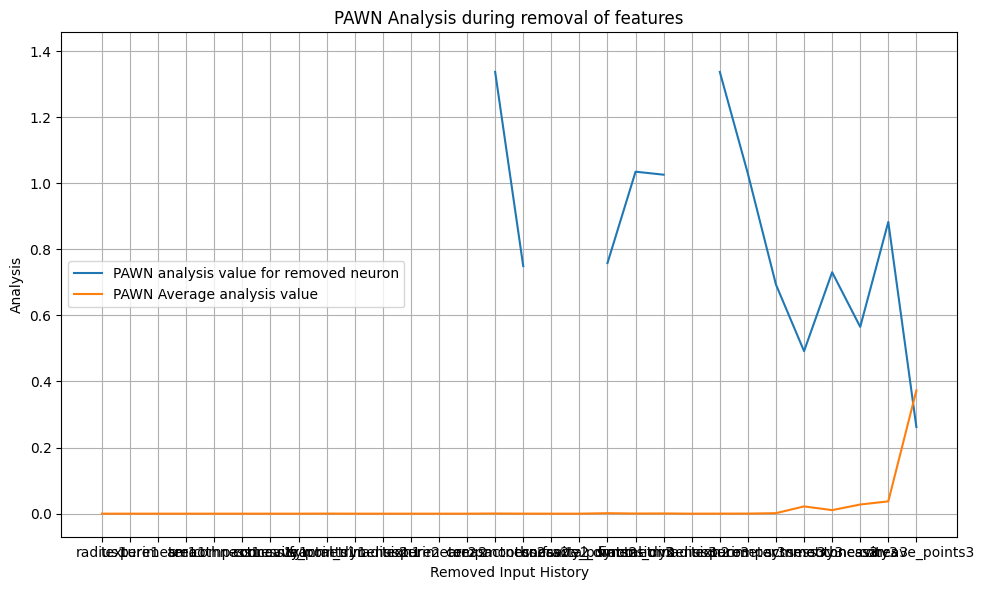

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_first_pawn)
print("train_accuracy_history:")
print(train_accuracy_history_first_pawn)
print("valid_accuracy_history:")
print(valid_accuracy_history_first_pawn)
print("test_accuracy_history:")
print(test_accuracy_history_first_pawn)
print("time_history:")
print(time_history_first_pawn)
plot_accuracy(removed_inputs_history_first_pawn, train_accuracy_history_first_pawn, valid_accuracy_history_first_pawn, test_accuracy_history_first_pawn)
plot_time(removed_inputs_history_first_pawn, time_history_first_pawn)
plot_analysis(removed_inputs_history_first_pawn, analysis_history_first_pawn, average_analysis_history_first_pawn, "PAWN")

# Usuwanie neuronów z drugiej warstwy - PAWN

In [ ]:
breast_cancer = fetch_ucirepo(id=17)
breast_cancer.data.targets['Diagnosis'] = breast_cancer.data.targets['Diagnosis'] == 'M'

X = breast_cancer.data.features
X = X.drop('radius1', axis=1)
X = X.drop('texture1', axis=1)
X = X.drop('perimeter1', axis=1)
X = X.drop('area1', axis=1)
X = X.drop('smoothness1', axis=1)
X = X.drop('compactness1', axis=1)
X = X.drop('concavity1', axis=1)
X = X.drop('concave_points1', axis=1)
X = X.drop('symmetry1', axis=1)


y = breast_cancer.data.targets

hidden_dim = 32


removed_inputs_history_second_pawn, train_accuracy_history_second_pawn, valid_accuracy_history_second_pawn, test_accuracy_history_second_pawn, time_history_second_pawn, analysis_history_second_pawn, average_analysis_history_second_pawn = trainWhileRemovingInputsBasedOnAnalysisForSecondLayer(X, y, hidden_dim, AnalysisMethod.PAWN)

<ipython-input-32-ca72834f6cae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_cancer.data.targets['Diagnosis'] = breast_cancer.data.targets['Diagnosis'] == 'M'
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.3742, Training Accuracy: 0.9912, Valid Accuracy: 0.9464, Test Accuracy: 0.9709
[PAWN] Dropping neuron with index 26 |  PAWN value =  0.00375 | Avg PAWN value: 0.00715 

---------------------------------------- Iteration 2 ----------------------------------------
Loss: 0.3897, Training Accuracy: 0.9648, Valid Accuracy: 0.9464, Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 8 |  PAWN value =  0.00822 | Avg PAWN value: 0.02751 

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 0.4011, Training Accuracy: 0.9765, Valid Accuracy: 0.9643, Test Accuracy: 0.9826


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 11 |  PAWN value =  0.00806 | Avg PAWN value: 0.05985 

---------------------------------------- Iteration 4 ----------------------------------------
Loss: 0.3920, Training Accuracy: 0.9883, Valid Accuracy: 0.9643, Test Accuracy: 0.9709


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 12 |  PAWN value =  0.01528 | Avg PAWN value: 0.05237 

---------------------------------------- Iteration 5 ----------------------------------------
Loss: 0.4176, Training Accuracy: 0.9619, Valid Accuracy: 0.9464, Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 9 |  PAWN value =  0.00146 | Avg PAWN value: 0.00482 

---------------------------------------- Iteration 6 ----------------------------------------
Loss: 0.4009, Training Accuracy: 0.9707, Valid Accuracy: 0.9464, Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 24 |  PAWN value =  0.00832 | Avg PAWN value: 0.03672 

---------------------------------------- Iteration 7 ----------------------------------------
Loss: 0.4090, Training Accuracy: 0.9531, Valid Accuracy: 0.9286, Test Accuracy: 0.9535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 17 |  PAWN value =  0.00556 | Avg PAWN value: 0.01596 

---------------------------------------- Iteration 8 ----------------------------------------
Loss: 0.4105, Training Accuracy: 0.9677, Valid Accuracy: 0.9464, Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 8 |  PAWN value =  0.00374 | Avg PAWN value: 0.01407 

---------------------------------------- Iteration 9 ----------------------------------------
Loss: 0.4067, Training Accuracy: 0.9853, Valid Accuracy: 0.9464, Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 5 |  PAWN value =  0.00376 | Avg PAWN value: 0.00969 

---------------------------------------- Iteration 10 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.4108, Training Accuracy: 0.9707, Valid Accuracy: 0.9464, Test Accuracy: 0.9767
[PAWN] Dropping neuron with index 5 |  PAWN value =  0.01098 | Avg PAWN value: 0.04598 

---------------------------------------- Iteration 11 ----------------------------------------
Loss: 0.4069, Training Accuracy: 0.9648, Valid Accuracy: 0.9643, Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 2 |  PAWN value =  0.01744 | Avg PAWN value: 0.05439 

---------------------------------------- Iteration 12 ----------------------------------------
Loss: 0.4496, Training Accuracy: 0.9707, Valid Accuracy: 0.9464, Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 15 |  PAWN value =  0.00394 | Avg PAWN value: 0.00863 

---------------------------------------- Iteration 13 ----------------------------------------
Loss: 0.4203, Training Accuracy: 0.9765, Valid Accuracy: 0.9464, Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 4 |  PAWN value =  0.00470 | Avg PAWN value: 0.01431 

---------------------------------------- Iteration 14 ----------------------------------------
Loss: 0.4385, Training Accuracy: 0.9472, Valid Accuracy: 0.9464, Test Accuracy: 0.9535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 8 |  PAWN value =  0.01313 | Avg PAWN value: 0.07320 

---------------------------------------- Iteration 15 ----------------------------------------
Loss: 0.4092, Training Accuracy: 0.9707, Valid Accuracy: 0.9464, Test Accuracy: 0.9709


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 3 |  PAWN value =  0.01258 | Avg PAWN value: 0.06570 

---------------------------------------- Iteration 16 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.4261, Training Accuracy: 0.9560, Valid Accuracy: 0.9464, Test Accuracy: 0.9651
[PAWN] Dropping neuron with index 14 |  PAWN value =  0.00434 | Avg PAWN value: 0.01480 

---------------------------------------- Iteration 17 ----------------------------------------
Loss: 0.4262, Training Accuracy: 0.9619, Valid Accuracy: 0.9464, Test Accuracy: 0.9535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 6 |  PAWN value =  0.00862 | Avg PAWN value: 0.06158 

---------------------------------------- Iteration 18 ----------------------------------------
Loss: 0.4460, Training Accuracy: 0.9619, Valid Accuracy: 0.9464, Test Accuracy: 0.9535


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 10 |  PAWN value =  0.00106 | Avg PAWN value: 0.00184 

---------------------------------------- Iteration 19 ----------------------------------------
Loss: 0.4102, Training Accuracy: 0.9648, Valid Accuracy: 0.9464, Test Accuracy: 0.9651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 3 |  PAWN value =  0.00823 | Avg PAWN value: 0.06567 

---------------------------------------- Iteration 20 ----------------------------------------
Loss: 0.4672, Training Accuracy: 0.9531, Valid Accuracy: 0.9464, Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 4 |  PAWN value =  0.00259 | Avg PAWN value: 0.00557 

---------------------------------------- Iteration 21 ----------------------------------------
Loss: 0.4626, Training Accuracy: 0.9765, Valid Accuracy: 0.9464, Test Accuracy: 0.9593


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 7 |  PAWN value =  0.00894 | Avg PAWN value: 0.07654 

---------------------------------------- Iteration 22 ----------------------------------------
Loss: 0.4542, Training Accuracy: 0.9413, Valid Accuracy: 0.9464, Test Accuracy: 0.9419


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 4 |  PAWN value =  0.00874 | Avg PAWN value: 0.02599 

---------------------------------------- Iteration 23 ----------------------------------------
Loss: 0.4905, Training Accuracy: 0.9413, Valid Accuracy: 0.9464, Test Accuracy: 0.9477


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 8 |  PAWN value =  0.00443 | Avg PAWN value: 0.01702 

---------------------------------------- Iteration 24 ----------------------------------------
Loss: 0.4714, Training Accuracy: 0.9267, Valid Accuracy: 0.9464, Test Accuracy: 0.9419


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 6 |  PAWN value =  0.00614 | Avg PAWN value: 0.09629 

---------------------------------------- Iteration 25 ----------------------------------------
Loss: 0.5150, Training Accuracy: 0.9267, Valid Accuracy: 0.9286, Test Accuracy: 0.9244


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 5 |  PAWN value =  0.00108 | Avg PAWN value: 0.00441 

---------------------------------------- Iteration 26 ----------------------------------------
Loss: 0.6225, Training Accuracy: 0.8446, Valid Accuracy: 0.7857, Test Accuracy: 0.8779


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 1 |  PAWN value =  0.01220 | Avg PAWN value: 0.05808 

---------------------------------------- Iteration 27 ----------------------------------------
Loss: 0.6221, Training Accuracy: 0.9062, Valid Accuracy: 0.8571, Test Accuracy: 0.9419


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 2 |  PAWN value =  0.02357 | Avg PAWN value: 0.09620 

---------------------------------------- Iteration 28 ----------------------------------------
Loss: 0.5440, Training Accuracy: 0.8592, Valid Accuracy: 0.8036, Test Accuracy: 0.8140


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 4 |  PAWN value =  0.00700 | Avg PAWN value: 0.00778 

---------------------------------------- Iteration 29 ----------------------------------------
Loss: 0.6133, Training Accuracy: 0.6393, Valid Accuracy: 0.6786, Test Accuracy: 0.5872


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[PAWN] Dropping neuron with index 0 |  PAWN value =  0.00000 | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 30 ----------------------------------------
Loss: 0.6398, Training Accuracy: 0.6628, Valid Accuracy: 0.6786, Test Accuracy: 0.6047
[PAWN] Dropping neuron with index 0 |  PAWN value =  0.00000 | Avg PAWN value: 0.00000 

---------------------------------------- Iteration 31 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 0.6215, Training Accuracy: 0.8944, Valid Accuracy: 0.8750, Test Accuracy: 0.9012
[PAWN] Dropping neuron with index 0 |  PAWN value =  0.14309 | Avg PAWN value: 0.25610 

---------------------------------------- Iteration 32 ----------------------------------------
Loss: 0.6978, Training Accuracy: 0.6393, Valid Accuracy: 0.6786, Test Accuracy: 0.5872
[PAWN] Dropping neuron with index 0 |  PAWN value =  0.00000 | Avg PAWN value: 0.00000 



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


removed_inputs_history:
[26, 8, 11, 12, 9, 24, 17, 8, 5, 5, 2, 15, 4, 8, 3, 14, 6, 10, 3, 4, 7, 4, 8, 6, 5, 1, 2, 4, 0, 0, 0, 0]
train_accuracy_history:
[0.9912023460410557, 0.9648093841642229, 0.9765395894428153, 0.9882697947214076, 0.9618768328445748, 0.9706744868035191, 0.9530791788856305, 0.967741935483871, 0.9853372434017595, 0.9706744868035191, 0.9648093841642229, 0.9706744868035191, 0.9765395894428153, 0.9472140762463344, 0.9706744868035191, 0.9560117302052786, 0.9618768328445748, 0.9618768328445748, 0.9648093841642229, 0.9530791788856305, 0.9765395894428153, 0.9413489736070382, 0.9413489736070382, 0.9266862170087976, 0.9266862170087976, 0.844574780058651, 0.906158357771261, 0.8592375366568915, 0.6392961876832844, 0.6627565982404692, 0.8944281524926686, 0.6392961876832844]
valid_accuracy_history:
[0.9464285714285714, 0.9464285714285714, 0.9642857142857143, 0.9642857142857143, 0.9464285714285714, 0.9464285714285714, 0.9285714285714286, 0.9464285714285714, 0.9464285714285714, 0.94

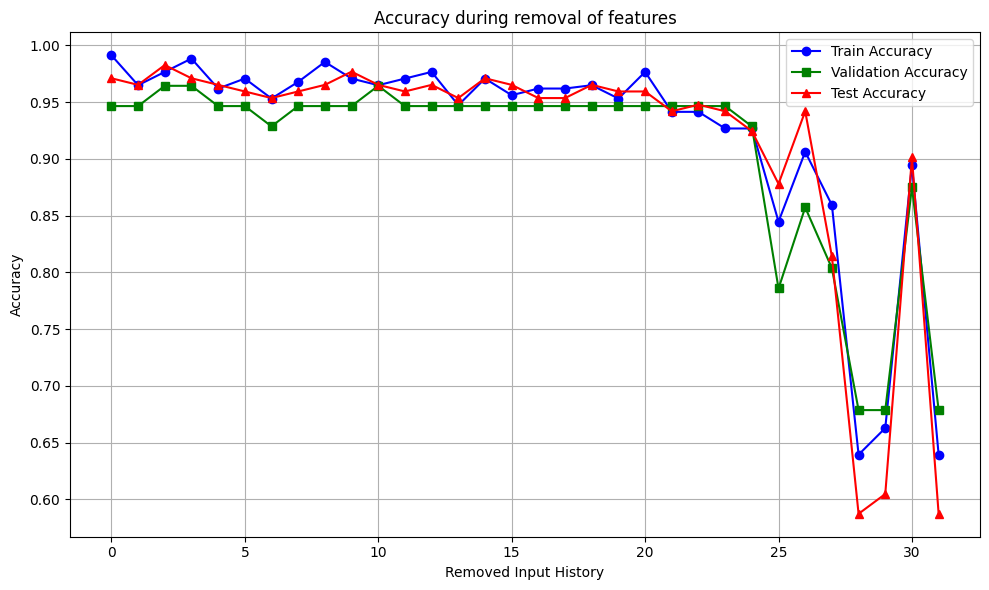

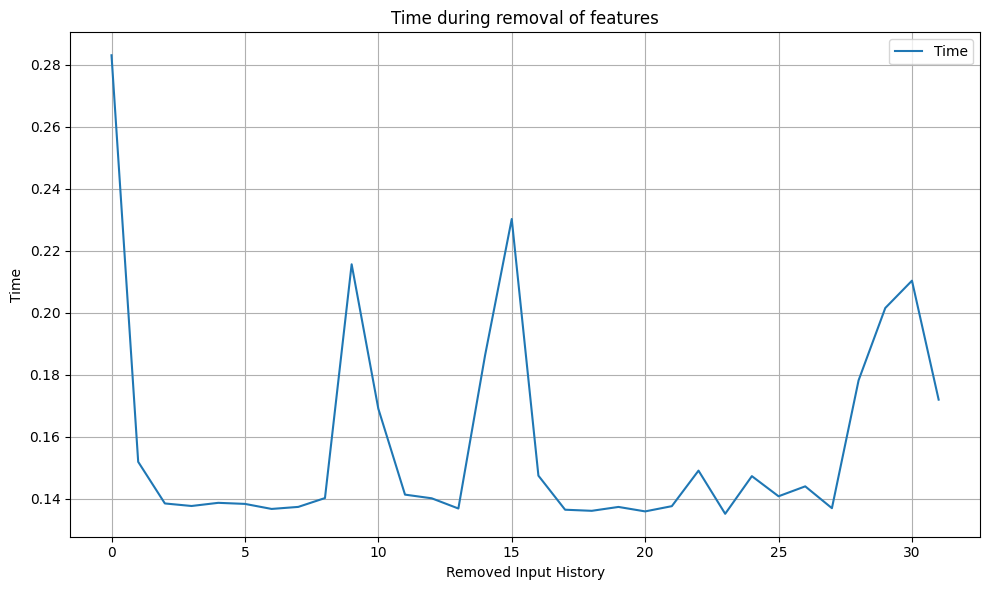

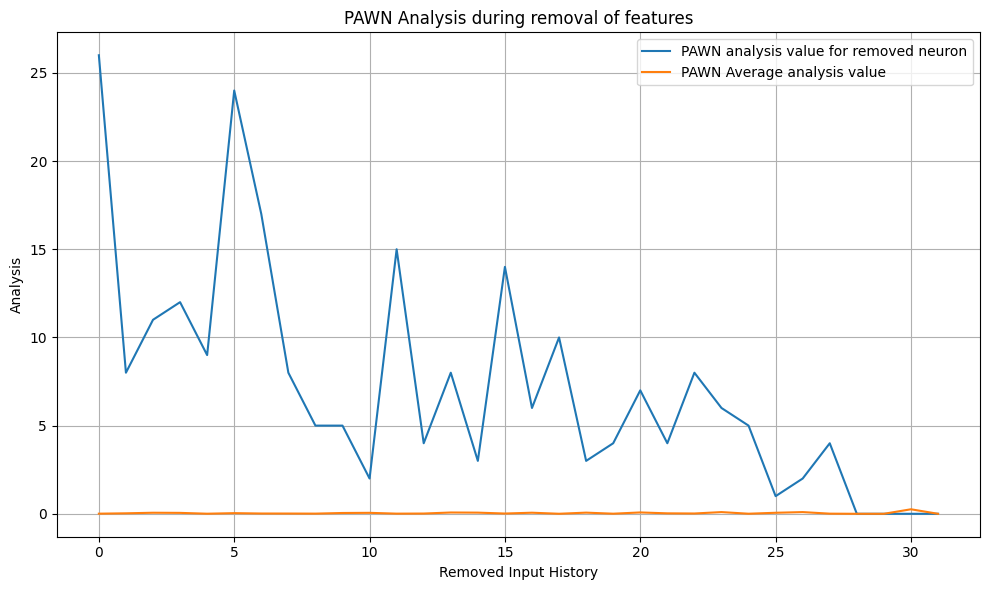

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_second_pawn)
print("train_accuracy_history:")
print(train_accuracy_history_second_pawn)
print("valid_accuracy_history:")
print(valid_accuracy_history_second_pawn)
print("test_accuracy_history:")
print(test_accuracy_history_second_pawn)
print("time_history:")
print(time_history_second_pawn)
plot_accuracy(None, train_accuracy_history_second_pawn, valid_accuracy_history_second_pawn, test_accuracy_history_second_pawn)
plot_time(None, time_history_second_pawn)
plot_analysis(None, analysis_history_second_pawn, average_analysis_history_second_pawn, "PAWN")